In [1]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\filip\AppData\Local\Temp\ipykernel_2428\3363569260.py:53: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = self.prices.pct_change()
C:\Users\filip\AppData\Local\Temp\ipykernel_2428\3363569260.py:94: FutureWarning: Setting an 

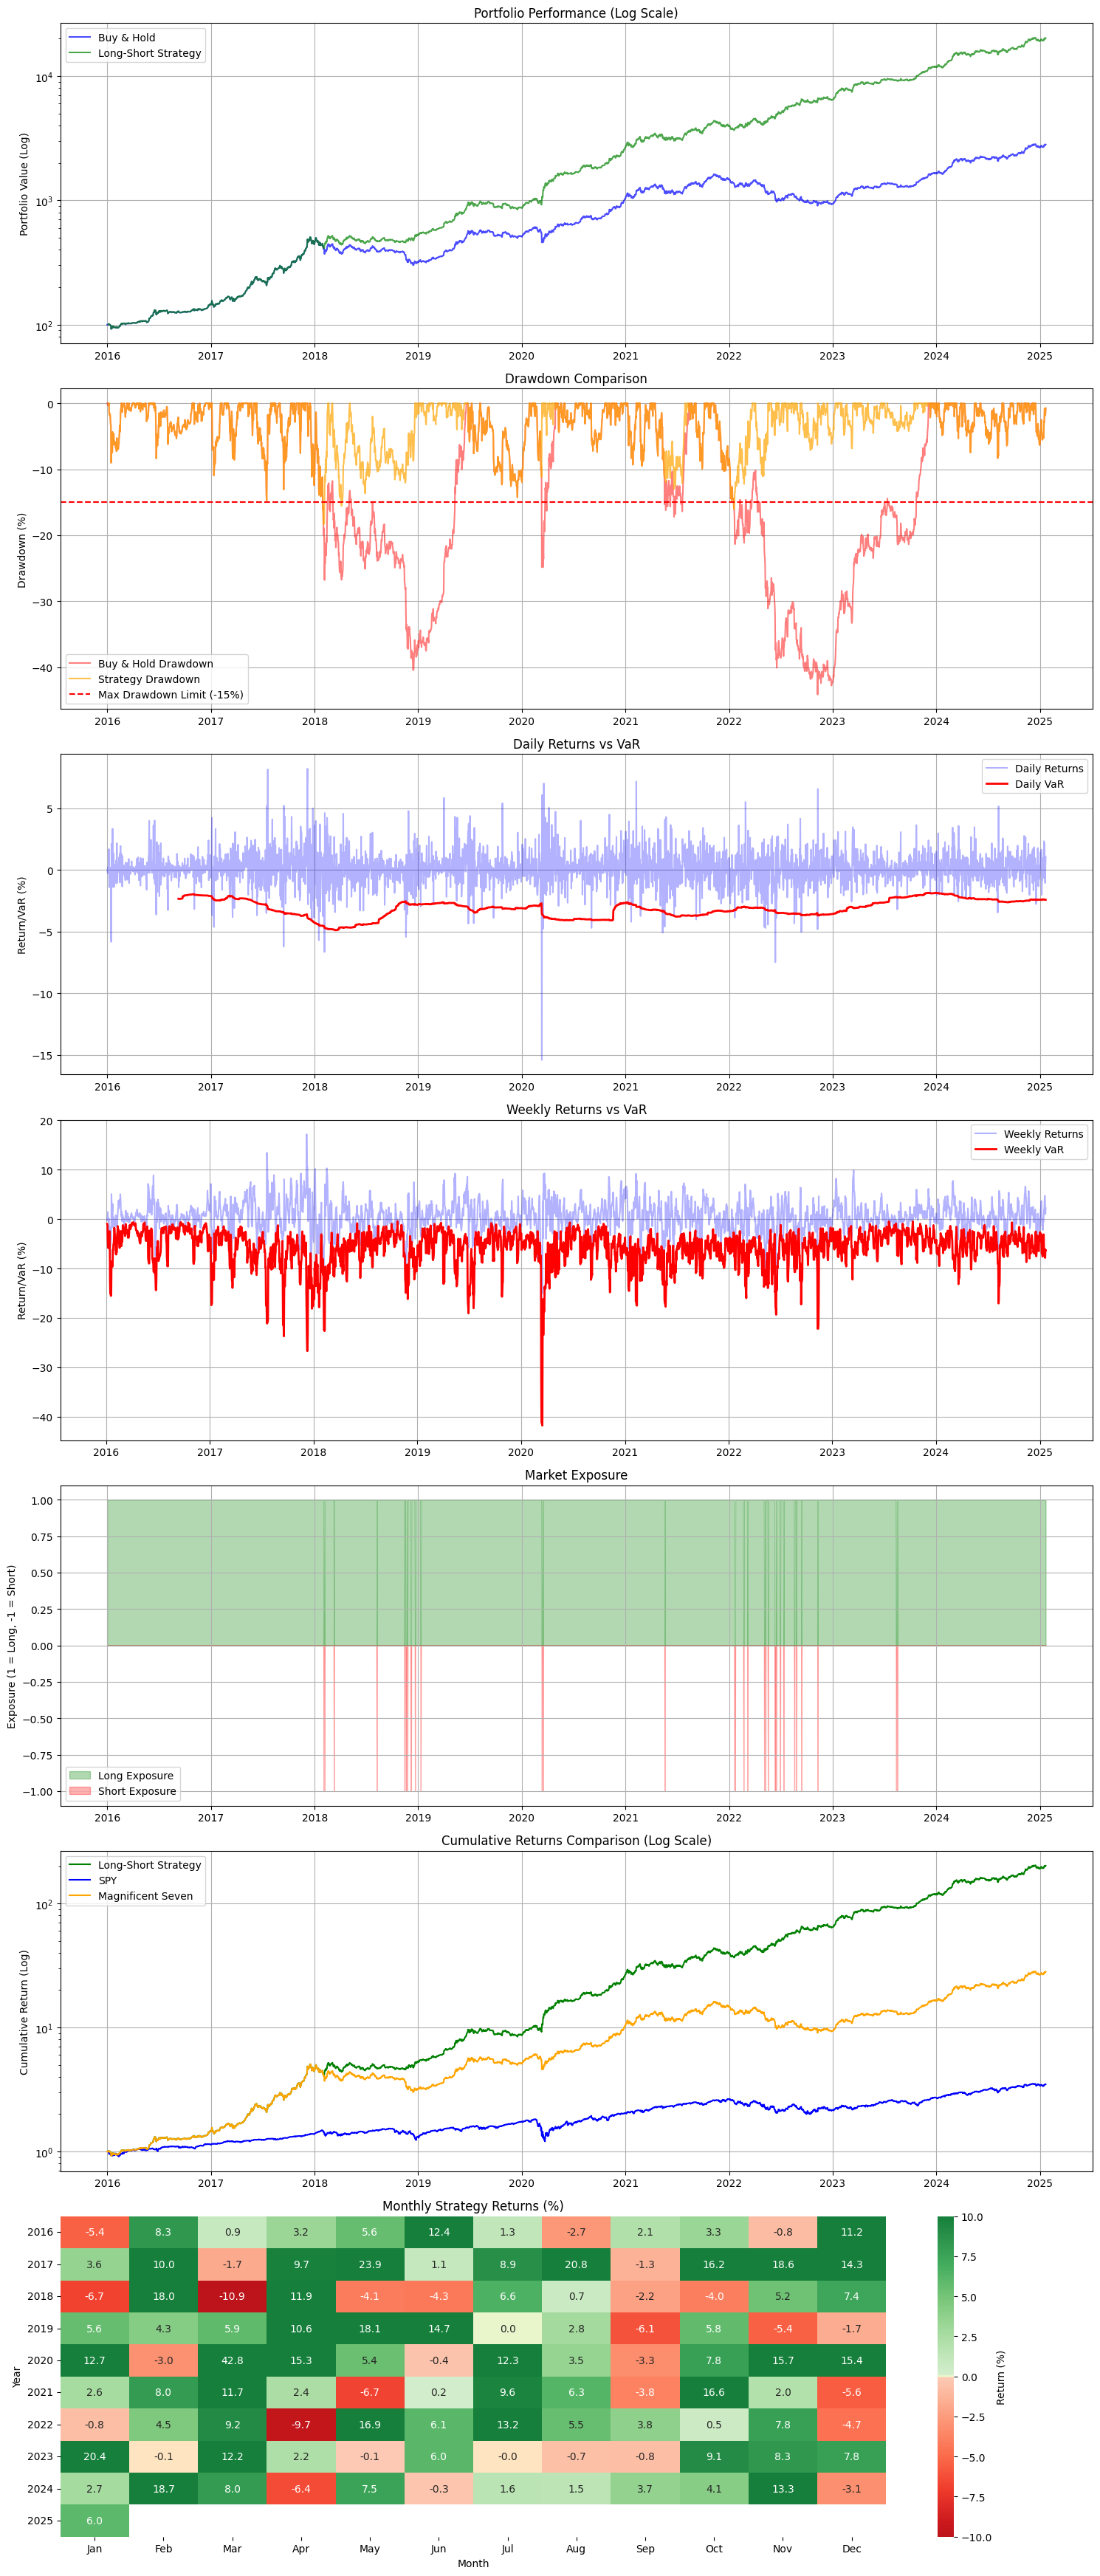


Pesos del Portfolio (Magnificent Seven):
EGLN.L: 17.70%
COST: 16.16%
BTC-USD: 33.33%
RACE: 8.84%
NVDA: 3.11%
META: 5.23%
TLT: 15.63%

=== Resultados del Backtest (2016-2024) ===

Estadísticas Buy & Hold (Magnificent Seven):
Rendimiento Total: 2709.61%
Rendimiento Anualizado: 28.92%
Volatilidad Anualizada: 21.48%
Ratio de Sharpe: 1.35
Máximo Drawdown: -44.13%
Ratio de Calmar: 0.66

Estadísticas Estrategia Long-Short:
Rendimiento Total: 20060.98%
Rendimiento Anualizado: 49.80%
Volatilidad Anualizada: 20.83%
Ratio de Sharpe: 2.39
Máximo Drawdown: -18.37%
Ratio de Calmar: 2.71
Exposición Long: 98.9%
Exposición Short: 1.1%
Número de Operaciones: 30


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
pd.options.mode.chained_assignment = None
plt.style.use('default')

class HRCLongShortManager:
    def __init__(self, start_date, n_clusters=3, confidence_level=0.99,
                 window=252, max_drawdown=-15):
        """
        Inicializa el gestor de portfolio con clustering jerárquico y estrategia long/short

        Parámetros:
        - start_date: Fecha de inicio para los datos históricos
        - n_clusters: Número de clusters para el análisis jerárquico
        - confidence_level: Nivel de confianza para el VaR
        - window: Ventana móvil para cálculos de volatilidad
        - max_drawdown: Límite de drawdown permitido
        """
        self.start_date = start_date
        self.n_clusters = n_clusters
        self.confidence_level = confidence_level
        self.window = window
        self.max_drawdown = max_drawdown
        self.magnificent_seven = ['EGLN.L', 'COST', 'BTC-USD', 'RACE', 'NVDA', 'META', 'TLT']

    def download_data(self):
        """
        Descarga y prepara los datos históricos incluyendo SPY como benchmark
        """
        symbols = self.magnificent_seven + ['SPY']
        df_list = []
        for symbol in symbols:
            try:
                data = yf.download(symbol, self.start_date)
                if 'Adj Close' in data.columns:
                    df = data['Adj Close']
                else:
                    df = data['Close']
                df_list.append(df)
            except Exception as e:
                print(f"Error downloading {symbol}: {e}")
                continue

        self.prices = pd.concat(df_list, axis=1)
        self.prices.columns = symbols
        self.returns = self.prices.pct_change()

        # Separar retornos de SPY y añadir información temporal
        self.spy_returns = self.returns['SPY']
        self.returns = self.returns[self.magnificent_seven]
        self.returns['Year'] = self.returns.index.year
        self.returns['Month'] = self.returns.index.month
        self.returns['Week'] = self.returns.index.isocalendar().week

        return self.returns

    def calculate_clusters(self):
        """
        Calcula clusters usando análisis jerárquico de correlaciones
        """
        corr_matrix = self.returns[self.magnificent_seven].corr()
        dist_matrix = np.sqrt(2 * (1 - corr_matrix))
        linkage_matrix = linkage(squareform(dist_matrix), method='ward')
        self.clusters = fcluster(linkage_matrix, self.n_clusters, criterion='maxclust')

        # Crear diccionario de clusters
        self.cluster_dict = {}
        for i, cluster in enumerate(self.clusters):
            if cluster not in self.cluster_dict:
                self.cluster_dict[cluster] = []
            self.cluster_dict[cluster].append(self.magnificent_seven[i])

        return self.cluster_dict

    def calculate_weights(self):
        """
        Calcula pesos del portfolio usando varianza inversa dentro de cada cluster
        """
        variances = self.returns[self.magnificent_seven].var()
        inv_variances = 1 / variances
        self.weights = pd.Series(0, index=self.magnificent_seven)

        for cluster in self.cluster_dict:
            cluster_assets = self.cluster_dict[cluster]
            cluster_inv_var = inv_variances[cluster_assets]
            cluster_weights = cluster_inv_var / cluster_inv_var.sum()
            self.weights[cluster_assets] = cluster_weights / self.n_clusters

        return self.weights

    def calculate_portfolio_metrics(self):
        """
        Calcula métricas de riesgo y señales de trading
        """
        # Calcular retornos y valor del portfolio
        self.portfolio_returns = (self.returns[self.magnificent_seven] * self.weights).sum(axis=1)
        self.portfolio_value = (1 + self.portfolio_returns).cumprod() * 100
        self.rolling_max = self.portfolio_value.expanding().max()
        self.drawdown = ((self.portfolio_value - self.rolling_max) / self.rolling_max) * 100

        # Calcular métricas de volatilidad
        self.daily_volatility = self.portfolio_returns.rolling(window=self.window).std()
        self.weekly_volatility = self.portfolio_returns.rolling(window=5).std() * np.sqrt(5)

        # Calcular VaR diario y semanal
        z_score = norm.ppf(1 - self.confidence_level)
        self.daily_var = self.daily_volatility * z_score
        self.weekly_var = self.weekly_volatility * z_score
        self.weekly_returns = self.portfolio_returns.rolling(window=5).sum()

        # Generar señales de riesgo
        self.risk_signals = pd.DataFrame(index=self.portfolio_returns.index)
        self.risk_signals['Drawdown_Stop'] = self.drawdown < self.max_drawdown
        self.risk_signals['Daily_VaR_Violation'] = self.portfolio_returns < self.daily_var
        self.risk_signals['Weekly_VaR_Violation'] = self.weekly_returns < self.weekly_var

        # Calcular señales activas y señal de short
        self.risk_signals['Active_Signals'] = (
            self.risk_signals['Drawdown_Stop'].astype(int) +
            self.risk_signals['Daily_VaR_Violation'].astype(int) +
            self.risk_signals['Weekly_VaR_Violation'].astype(int)
        )
        self.risk_signals['Short_Signal'] = self.risk_signals['Active_Signals'] >= 2

        return self.risk_signals

    def plot_portfolio_analysis(self, backtest):
        """
        Genera visualizaciones completas del análisis del portfolio
        """
        fig, axes = plt.subplots(7, 1, figsize=(15, 35))

        # 1. Gráfico de rendimiento (escala logarítmica)
        axes[0].semilogy(backtest.index, backtest['Buy_Hold_Equity'],
                        label='Buy & Hold', color='blue', alpha=0.7)
        axes[0].semilogy(backtest.index, backtest['Strategy_Equity'],
                        label='Long-Short Strategy', color='green', alpha=0.7)
        axes[0].set_title('Portfolio Performance (Log Scale)')
        axes[0].set_ylabel('Portfolio Value (Log)')
        axes[0].legend()
        axes[0].grid(True)

        # 2. Gráfico de drawdown
        axes[1].plot(backtest.index, backtest['BH_Drawdown'],
                    label='Buy & Hold Drawdown', color='red', alpha=0.5)
        axes[1].plot(backtest.index, backtest['Strategy_Drawdown'],
                    label='Strategy Drawdown', color='orange', alpha=0.7)
        axes[1].axhline(y=self.max_drawdown, color='r', linestyle='--',
                       label=f'Max Drawdown Limit ({self.max_drawdown}%)')
        axes[1].set_title('Drawdown Comparison')
        axes[1].set_ylabel('Drawdown (%)')
        axes[1].legend()
        axes[1].grid(True)

        # 3. VaR diario
        axes[2].plot(self.portfolio_returns.index, self.portfolio_returns * 100,
                    label='Daily Returns', color='blue', alpha=0.3)
        axes[2].plot(self.daily_var.index, self.daily_var * 100,
                    label='Daily VaR', color='red', linewidth=2)
        axes[2].set_title('Daily Returns vs VaR')
        axes[2].set_ylabel('Return/VaR (%)')
        axes[2].legend()
        axes[2].grid(True)

        # 4. VaR semanal
        axes[3].plot(self.weekly_returns.index, self.weekly_returns * 100,
                    label='Weekly Returns', color='blue', alpha=0.3)
        axes[3].plot(self.weekly_var.index, self.weekly_var * 100,
                    label='Weekly VaR', color='red', linewidth=2)
        axes[3].set_title('Weekly Returns vs VaR')
        axes[3].set_ylabel('Return/VaR (%)')
        axes[3].legend()
        axes[3].grid(True)

        # 5. Exposición al mercado
        axes[4].fill_between(backtest.index, 0, backtest['Long_Position'],
                           label='Long Exposure', color='green', alpha=0.3)
        axes[4].fill_between(backtest.index, 0, backtest['Short_Position'],
                           label='Short Exposure', color='red', alpha=0.3)
        axes[4].set_title('Market Exposure')
        axes[4].set_ylabel('Exposure (1 = Long, -1 = Short)')
        axes[4].legend()
        axes[4].grid(True)

        # 6. Comparación de retornos acumulados
        cum_strategy = (1 + backtest['Strategy_Returns']).cumprod()
        cum_spy = (1 + backtest['SPY_Returns']).cumprod()
        cum_long = (1 + backtest['Long_Returns']).cumprod()

        axes[5].semilogy(backtest.index, cum_strategy, label='Long-Short Strategy', color='green')
        axes[5].semilogy(backtest.index, cum_spy, label='SPY', color='blue')
        axes[5].semilogy(backtest.index, cum_long, label='Magnificent Seven', color='orange')
        axes[5].set_title('Cumulative Returns Comparison (Log Scale)')
        axes[5].set_ylabel('Cumulative Return (Log)')
        axes[5].legend()
        axes[5].grid(True)

        # 7. Mapa de calor de retornos mensuales con colores personalizados
        monthly_returns = backtest['Strategy_Returns'].resample('M').apply(
            lambda x: (1 + x).prod() - 1) * 100
        monthly_returns_matrix = monthly_returns.to_frame()
        monthly_returns_matrix.index = pd.MultiIndex.from_arrays([
            monthly_returns_matrix.index.year,
            monthly_returns_matrix.index.month
        ])
        monthly_returns_pivot = monthly_returns_matrix.pivot_table(
            index=monthly_returns_matrix.index.get_level_values(0),
            columns=monthly_returns_matrix.index.get_level_values(1),
            values='Strategy_Returns'
        )

        # Crear mapa de colores personalizado
        colors_red = plt.cm.Reds(np.linspace(0.2, 0.8, 128))
        colors_green = plt.cm.Greens(np.linspace(0.2, 0.8, 128))
        colors = np.vstack([colors_red[::-1],
                           [1, 1, 0.8, 1],  # Amarillo suave para valores cercanos a cero
                           colors_green])
        custom_cmap = LinearSegmentedColormap.from_list('custom_diverging', colors)

        # Crear mapa de calor con la nueva escala de colores
        sns.heatmap(monthly_returns_pivot,
                   ax=axes[6],
                   cmap=custom_cmap,
                   center=0,
                   annot=True,
                   fmt='.1f',
                   vmin=-10,  # Límite inferior para estandarizar la escala
                   vmax=10,   # Límite superior para estandarizar la escala
                   cbar_kws={'label': 'Return (%)'})

        axes[6].set_title('Monthly Strategy Returns (%)')
        axes[6].set_xlabel('Month')
        axes[6].set_ylabel('Year')

        month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        axes[6].set_xticklabels(month_labels)

        plt.tight_layout()
        plt.show()

        # Imprimir pesos del portfolio
        print("\nPesos del Portfolio (Magnificent Seven):")
        for asset, weight in self.weights.items():
            print(f"{asset}: {weight:.2%}")

    def backtest_portfolio(self):
        """
        Realiza el backtesting completo del portfolio
        """
        backtest = pd.DataFrame(index=self.portfolio_returns.index)
        backtest['Long_Returns'] = self.portfolio_returns
        backtest['SPY_Returns'] = self.spy_returns
        backtest['Risk_Signal'] = self.risk_signals['Short_Signal']

        backtest['Long_Position'] = (~backtest['Risk_Signal']).astype(int)
        backtest['Short_Position'] = backtest['Risk_Signal'].astype(int) * -1

        backtest['Strategy_Returns'] = (backtest['Long_Returns'] * backtest['Long_Position'] +
                                      backtest['SPY_Returns'] * backtest['Short_Position'])

        # Calcular equity curves
        initial_capital = 100
        backtest['Buy_Hold_Equity'] = (1 + backtest['Long_Returns']).cumprod() * initial_capital
        backtest['Strategy_Equity'] = (1 + backtest['Strategy_Returns']).cumprod() * initial_capital

        # Calcular drawdowns
        backtest['BH_Drawdown'] = (backtest['Buy_Hold_Equity'] /
                                  backtest['Buy_Hold_Equity'].expanding().max() - 1) * 100
        backtest['Strategy_Drawdown'] = (backtest['Strategy_Equity'] /
                                       backtest['Strategy_Equity'].expanding().max() - 1) * 100

        # Calcular y mostrar estadísticas
        trading_days = 252
        total_days = len(backtest)
        years = total_days / trading_days

        stats = self._calculate_performance_stats(backtest, years, trading_days, initial_capital)
        self.plot_portfolio_analysis(backtest)
        self._print_performance_stats(stats)

        return
    def _calculate_performance_stats(self, backtest, years, trading_days, initial_capital):
        """
        Calcula estadísticas detalladas de rendimiento para la estrategia y el benchmark

        Parámetros:
        - backtest: DataFrame con los resultados del backtest
        - years: Número de años en el backtest
        - trading_days: Número de días de trading por año
        - initial_capital: Capital inicial de la estrategia

        Retorna:
        - Dictionary con estadísticas completas de rendimiento
        """
        # Calcular retornos totales
        bh_total_return = (backtest['Buy_Hold_Equity'].iloc[-1] / initial_capital - 1) * 100
        strategy_total_return = (backtest['Strategy_Equity'].iloc[-1] / initial_capital - 1) * 100

        # Crear diccionario de estadísticas
        stats = {
            'buy_hold': {
                'total_return': bh_total_return,
                'annual_return': ((1 + bh_total_return/100) ** (1/years) - 1) * 100,
                'volatility': backtest['Long_Returns'].std() * np.sqrt(trading_days) * 100,
                'max_drawdown': backtest['BH_Drawdown'].min()
            },
            'strategy': {
                'total_return': strategy_total_return,
                'annual_return': ((1 + strategy_total_return/100) ** (1/years) - 1) * 100,
                'volatility': backtest['Strategy_Returns'].std() * np.sqrt(trading_days) * 100,
                'max_drawdown': backtest['Strategy_Drawdown'].min(),
                'long_exposure': (backtest['Long_Position'].sum() / len(backtest)) * 100,
                'short_exposure': (-backtest['Short_Position'].sum() / len(backtest)) * 100,
                'trades': ((backtest['Long_Position'] != backtest['Long_Position'].shift(1)) |
                         (backtest['Short_Position'] != backtest['Short_Position'].shift(1))).sum() / 2
            }
        }

        # Calcular ratios de rendimiento ajustado al riesgo
        stats['buy_hold']['sharpe'] = stats['buy_hold']['annual_return'] / stats['buy_hold']['volatility']
        stats['buy_hold']['calmar'] = abs(stats['buy_hold']['annual_return'] / stats['buy_hold']['max_drawdown'])
        stats['strategy']['sharpe'] = stats['strategy']['annual_return'] / stats['strategy']['volatility']
        stats['strategy']['calmar'] = abs(stats['strategy']['annual_return'] / stats['strategy']['max_drawdown'])

        return stats

    def _print_performance_stats(self, stats):
        """
        Imprime un resumen detallado de las estadísticas de rendimiento

        Parámetros:
        - stats: Diccionario con las estadísticas calculadas
        """
        print("\n=== Resultados del Backtest (2016-2024) ===")
        print("\nEstadísticas Buy & Hold (Magnificent Seven):")
        print(f"Rendimiento Total: {stats['buy_hold']['total_return']:.2f}%")
        print(f"Rendimiento Anualizado: {stats['buy_hold']['annual_return']:.2f}%")
        print(f"Volatilidad Anualizada: {stats['buy_hold']['volatility']:.2f}%")
        print(f"Ratio de Sharpe: {stats['buy_hold']['sharpe']:.2f}")
        print(f"Máximo Drawdown: {stats['buy_hold']['max_drawdown']:.2f}%")
        print(f"Ratio de Calmar: {stats['buy_hold']['calmar']:.2f}")

        print("\nEstadísticas Estrategia Long-Short:")
        print(f"Rendimiento Total: {stats['strategy']['total_return']:.2f}%")
        print(f"Rendimiento Anualizado: {stats['strategy']['annual_return']:.2f}%")
        print(f"Volatilidad Anualizada: {stats['strategy']['volatility']:.2f}%")
        print(f"Ratio de Sharpe: {stats['strategy']['sharpe']:.2f}")
        print(f"Máximo Drawdown: {stats['strategy']['max_drawdown']:.2f}%")
        print(f"Ratio de Calmar: {stats['strategy']['calmar']:.2f}")
        print(f"Exposición Long: {stats['strategy']['long_exposure']:.1f}%")
        print(f"Exposición Short: {stats['strategy']['short_exposure']:.1f}%")
        print(f"Número de Operaciones: {stats['strategy']['trades']:.0f}")


if __name__ == "__main__":
    # Crear instancia del gestor de portfolio
    portfolio_manager = HRCLongShortManager('2016-01-01')

    # Ejecutar el proceso completo de análisis
    returns = portfolio_manager.download_data()
    clusters = portfolio_manager.calculate_clusters()
    weights = portfolio_manager.calculate_weights()
    risk_signals = portfolio_manager.calculate_portfolio_metrics()
    backtest_results = portfolio_manager.backtest_portfolio()